In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model
import matplotlib.pyplot as plt

/tmp/ipykernel_1407/248538872.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Multiplicative Model

Sometimes it is more reasonable to fit a model on the logarithmic scale, so that effects are multiplicative rather than additive.
Why?
1. *Noise*: In the linear model we assume an equal variance for the resiaduals. This might not be the case. In some applications, we expect to see higher noise when the mean is higher.
2. *Non-negativity*: Multiplicative model ensures that we have always non-negative values. (There are other ways to achieve this).
3. *Domain Definitions*: For example price elasticity is already defined as a multiplicative term: $\frac{\frac{\Delta Q}{Q_0}}{\frac{\Delta P}{P_0}}$
4. *Pooling*: Assume that we want to share information (learned parameters) between some products. Suppose that a new product is introduced and we may want the coefficients for this new product should be close to the coefficients of the similar products. For the additive model this is much difficult, a product selling 10units/day and another product selling 1,000 units/day would have lift values in different scales for the additive model.

In [2]:
plt.style.use("fivethirtyeight")

In [3]:
dates = pd.date_range("2020", "2024")

In [4]:
n = len(dates)

In [5]:
is_promoted = np.random.randint(0, 2, size=n)

In [6]:
pd.Series(is_promoted)

0       1
1       1
2       0
3       1
4       0
       ..
1457    1
1458    1
1459    1
1460    1
1461    1
Length: 1462, dtype: int64

In [7]:
promo_lift_multiplier = 4
regular_sales = 100 

In [8]:
#sales = np.exp(np.ones(n) * np.log(regular_sales) + np.random.normal(size=n)*1 )
sales = np.exp(np.ones(n) * np.log(regular_sales) + (is_promoted * promo_lift_multiplier) + np.random.normal(size=n)*1 )

In [9]:
df = pd.DataFrame(data=[dates, is_promoted, sales], index=["date", "is_promoted", "sales"] ).T.set_index("date")

/home/codespace/.local/lib/python3.10/site-packages/pandas/core/indexes/base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [10]:
df["sales"] = df["sales"].astype("float")

<Axes: xlabel='date'>

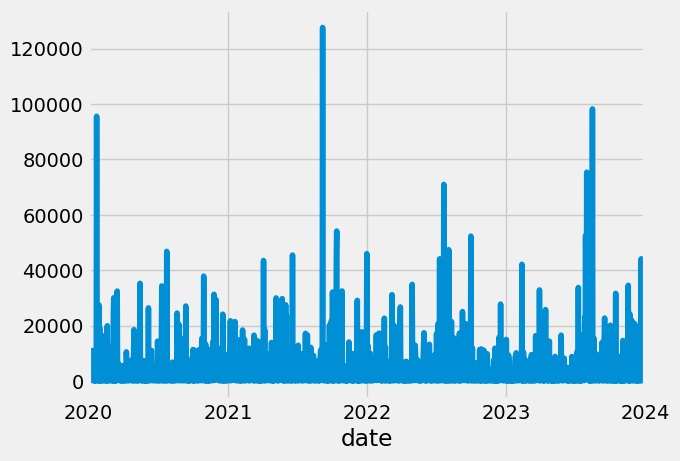

In [11]:
df["sales"].plot()

In [12]:
#df["sales"].mean()

In [13]:
#np.exp(df["sales"].apply(lambda x: np.log(x)).mean() + df["sales"].apply(lambda x: np.log(x)).std()**2 / 2)

In [14]:
#np.exp(df["sales"].apply(lambda x: np.log(x)).mean() + (1)**2/2)

In [15]:
df[df["is_promoted"]==0]["sales"].mean()

172.48532053040478

In [16]:
reg = linear_model.LinearRegression()

In [17]:
X = df["is_promoted"].to_numpy().reshape(-1, 1)
y = np.log(df["sales"])

In [18]:
reg.fit(X, y).coef_

array([3.95851733])

In [19]:
df_weekly = df.resample("W").apply({"is_promoted": "max", "sales": "sum"})

In [20]:
X = df_weekly["is_promoted"].to_numpy().reshape(-1, 1)
y = np.log(df_weekly["sales"])

In [21]:
reg.fit(X, y).coef_

array([2.44740355])

In [22]:
df

,is_promoted,sales
date,,
2020-01-01,1,1140.813847
2020-01-02,1,3755.278307
2020-01-03,0,139.395565
2020-01-04,1,5303.706367
2020-01-05,0,113.261207
...,...,...
2023-12-28,1,4929.430661
2023-12-29,1,24628.162867
2023-12-30,1,2126.584220


In [23]:
df["week"] = df.reset_index()["date"].dt.isocalendar().week.values

In [24]:
df["odd_weeks"] = df["week"].apply(lambda x: x%2)

In [25]:
df

,is_promoted,sales,week,odd_weeks
date,,,,
2020-01-01,1,1140.813847,1,1
2020-01-02,1,3755.278307,1,1
2020-01-03,0,139.395565,1,1
2020-01-04,1,5303.706367,1,1
2020-01-05,0,113.261207,1,1
...,...,...,...,...
2023-12-28,1,4929.430661,52,0
2023-12-29,1,24628.162867,52,0
2023-12-30,1,2126.584220,52,0


In [26]:
df["odd_weeks"].values

array([1, 1, 1, ..., 0, 0, 1])

In [27]:
sales = np.exp(np.ones(n) * np.log(regular_sales) + (df["odd_weeks"].values * promo_lift_multiplier) + np.random.normal(size=n) * 1 )

In [28]:
df = pd.DataFrame(data=[dates, df["odd_weeks"], sales], index=["date", "is_promoted", "sales"] ).T.set_index("date")

/home/codespace/.local/lib/python3.10/site-packages/pandas/core/indexes/base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [29]:
df

,is_promoted,sales
date,,
2020-01-01,1,4496.755556
2020-01-02,1,5497.06062
2020-01-03,1,8903.59086
2020-01-04,1,8227.44214
2020-01-05,1,5014.525219
...,...,...
2023-12-28,0,37.18802
2023-12-29,0,280.500043
2023-12-30,0,39.569389


In [30]:
df["sales"] = df["sales"].astype("float")

<Axes: xlabel='date'>

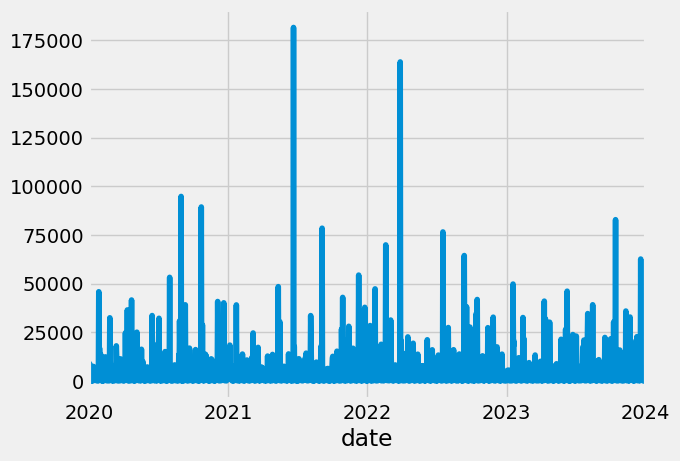

In [31]:
df["sales"].plot()

In [32]:
X = df["is_promoted"].to_numpy().reshape(-1, 1)
y = np.log(df["sales"])

In [33]:
reg.fit(X, y).coef_

array([4.08965901])

In [34]:
df_weekly = df.resample("W").apply({"is_promoted": "max", "sales": "sum"})

In [35]:
X = df_weekly["is_promoted"].to_numpy().reshape(-1, 1)
y = np.log(df_weekly["sales"])

In [36]:
_coefficient, _intercept =  reg.fit(X, y).coef_, reg.fit(X, y).intercept_

In [37]:
df_weekly

,is_promoted,sales
date,,
2020-01-05,1,32139.374395
2020-01-12,0,1083.174744
2020-01-19,1,33619.243758
2020-01-26,0,1085.917846
2020-02-02,1,111186.887588
...,...,...
2023-12-10,1,95256.044918
2023-12-17,0,1623.913643
2023-12-24,1,89827.879262


In [38]:
df[df["is_promoted"] == 0]["sales"].mean() * np.exp(_coefficient)

array([9092.71458913])

In [39]:
df[df["is_promoted"] == 1]["sales"].mean()

9654.152629481907

In [40]:
np.exp(_intercept + _coefficient + 1/2)

array([95460.51531289])

In [41]:
(df_weekly[df_weekly["is_promoted"] == 0]["sales"].mean() / 7) * np.exp(_coefficient)

array([9092.71458913])

In [42]:
actuals = df_weekly["sales"].astype("float")

In [43]:
estimations = np.exp(((df_weekly["is_promoted"] * _coefficient) + _intercept).astype("float"))

In [44]:
correction_term = (np.log(actuals) - np.log(estimations)).std()**2 / 2

In [45]:
correction_term

0.12448324967613558

In [46]:
correction_term2 = (np.log(df_weekly[df_weekly["is_promoted"]==0]["sales"])).std()**2 / 2

In [47]:
corrected_estimations = np.exp(((df_weekly["is_promoted"] * _coefficient) + _intercept + correction_term).astype("float"))

In [48]:
corrected_estimations2 = np.exp(((df_weekly["is_promoted"] * _coefficient) + _intercept + correction_term2).astype("float"))

In [49]:
non_promoted_average_sales = df_weekly[df_weekly["is_promoted"] == 0]["sales"].mean()

In [50]:
estimations_2 = np.exp(((df_weekly["is_promoted"] * _coefficient) + np.log(non_promoted_average_sales)).astype("float"))

In [51]:
(np.log(actuals) - np.log(estimations)).mean()

-4.017949993881519e-16

In [52]:
(actuals - estimations).mean() / actuals.mean()

0.13322229855274703

In [53]:
(actuals - estimations_2).mean() / actuals.mean()

0.047153822660589075

In [54]:
(actuals - corrected_estimations2).mean() / actuals.mean()

0.04716811221698597

In [55]:
(actuals - corrected_estimations).mean() / actuals.mean()

0.018319603207278174

In [56]:
corrected_estimations.max(), corrected_estimations2.max(), estimations_2.max(), estimations.max()

(65575.09401454375, 63648.047598346, 63649.00212387917, 57899.72932923412)

<Axes: xlabel='date'>

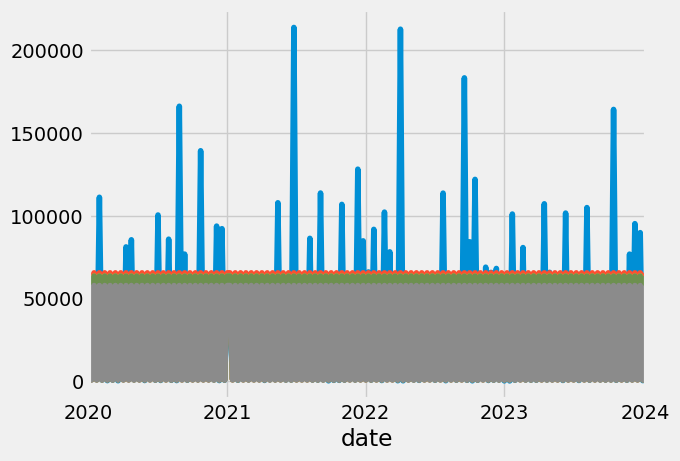

In [57]:
actuals.plot()
corrected_estimations.plot()
corrected_estimations2.plot()
estimations_2.plot()
estimations.plot()

In [187]:
results = []
corrections = []
odd_weeks = pd.Series(dates).dt.isocalendar().week.values % 2
reg = linear_model.LinearRegression()
reg2 = linear_model.LinearRegression(positive=True)
promo_lift_multiplier = 2
regular_sales = 100 

for _ in range(10_000):
    sales = np.exp(np.ones(n) * np.log(regular_sales) + (odd_weeks * promo_lift_multiplier) + np.random.normal(size=n) * 1 )
    df = pd.concat([pd.Series(dates).rename("date"), pd.Series(odd_weeks).rename("is_promoted"), pd.Series(sales).rename("sales")], axis=1).set_index("date")

    df_weekly = df.resample("W").apply({"is_promoted": "max", "sales": "sum"})
    df_weekly["sales"] = df_weekly["sales"].astype("float")
    
    X = df_weekly["is_promoted"].to_numpy().reshape(-1, 1)
    y = np.log(df_weekly["sales"])

    _coefficient, _intercept =  reg.fit(X, y).coef_, reg.fit(X, y).intercept_
    _coefficient2, _intercept2 = reg2.fit(X, np.exp(y)).coef_, reg2.fit(X, np.exp(y)).intercept_

    actuals = df_weekly["sales"].astype("float")
    
    estimations = np.exp(((df_weekly["is_promoted"] * _coefficient) + _intercept).astype("float"))
    non_promoted_average_sales = df_weekly[df_weekly["is_promoted"] == 0]["sales"].mean()
    estimations_2 = np.exp(((df_weekly["is_promoted"] * _coefficient) + np.log(non_promoted_average_sales)).astype("float"))
    estimations_3 = (((df_weekly["is_promoted"] * _coefficient2) + _intercept2).astype("float"))
    
    correction_term = (np.log(actuals) - np.log(estimations)).std()**2 / 2
    correction_term2 = (np.log(df_weekly[df_weekly["is_promoted"]==0]["sales"])).std()**2 / 2

    corrected_estimations = np.exp(((df_weekly["is_promoted"] * _coefficient) + _intercept + correction_term).astype("float"))
    corrected_estimations2 = np.exp(((df_weekly["is_promoted"] * _coefficient) + _intercept + correction_term2).astype("float"))

    results.append(
        {
        "log y - (ax + b)": (np.log(actuals) - np.log(estimations)).mean(),
        "y - exp(ax + b)": (actuals - estimations).mean() / actuals.mean(),
        "y - exp(ax + level)": (actuals - estimations_2).mean() / actuals.mean(),
        "y - exp(ax + b + std(residual)**2/2)": (actuals - corrected_estimations).mean() / actuals.mean(),
        "y - exp(ax + b + std(level)**2/2)": (actuals - corrected_estimations2).mean() / actuals.mean(),
        "y - (ax + b) // positive weights": (actuals - estimations_3).mean() / actuals.mean(),
         }
    )
    corrections.append(
        {
            "correction from residuals": correction_term,
            "correction from level": correction_term2,
        }
    )
    

In [188]:
results_df = pd.DataFrame(results).round(2)

In [189]:
#results_df.columns = ["log y - (ax + b)", 
#"y - exp(ax + b)", "y - exp(ax + level)", "y - exp(ax + b + std(residual)**2/2)", "y - exp(ax + b + std(level)**2/2)"]

array([[<Axes: title={'center': 'log y - (ax + b)'}>,
        <Axes: title={'center': 'y - exp(ax + b)'}>],
       [<Axes: title={'center': 'y - exp(ax + level)'}>,
        <Axes: title={'center': 'y - exp(ax + b + std(residual)**2/2)'}>],
       [<Axes: title={'center': 'y - exp(ax + b + std(level)**2/2)'}>,
        <Axes: title={'center': 'y - (ax + b) // positive weights'}>]],
      dtype=object)

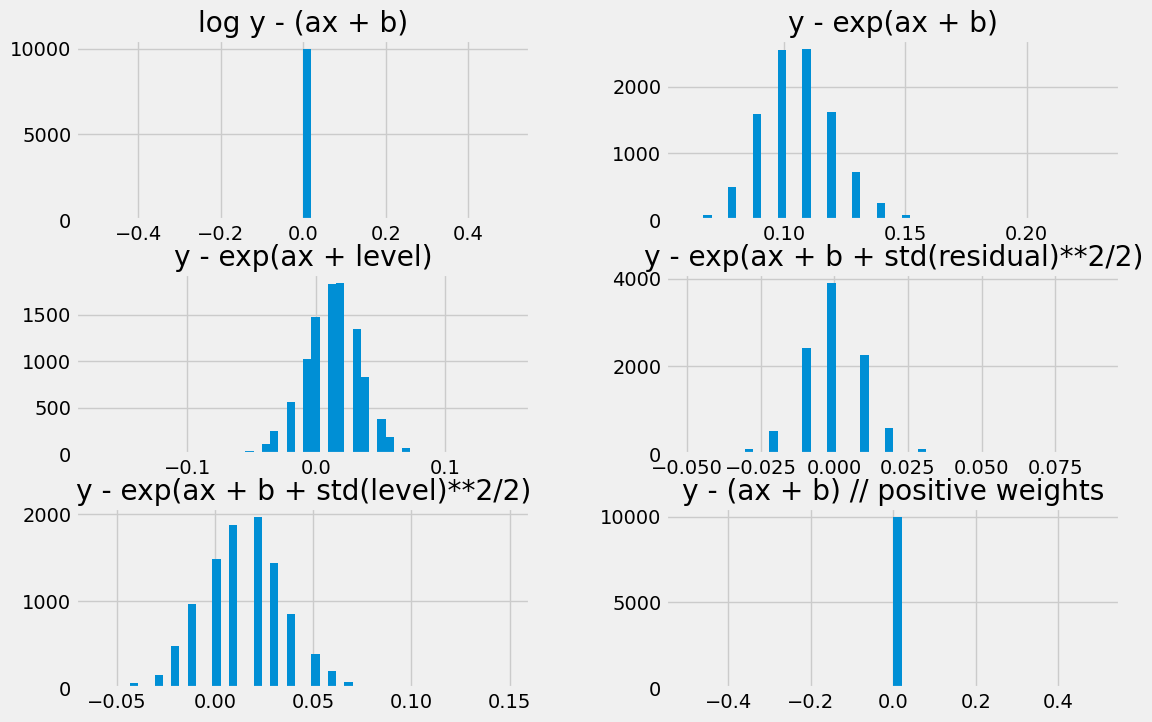

In [190]:
results_df.hist(bins=50, figsize=(12,8), sharex=False)

In [191]:
def q10(x):
    return x.quantile(0.10)

def q90(x):
    return x.quantile(0.90)

<Axes: >

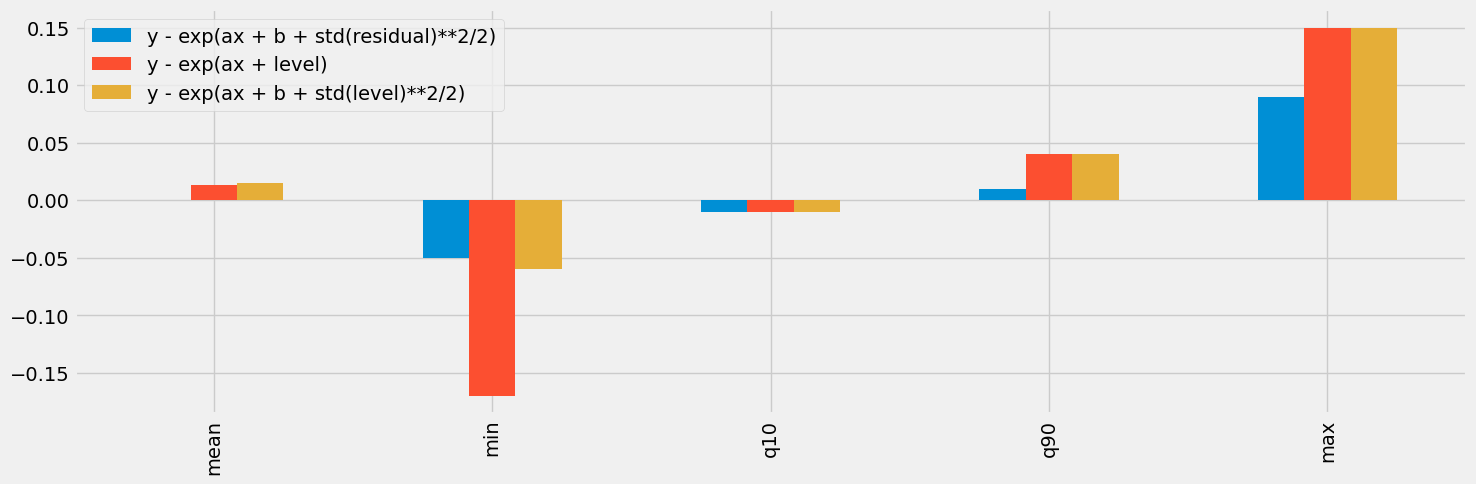

In [192]:
(results_df
.drop("y - exp(ax + b)", axis=1)
.drop("log y - (ax + b)", axis=1)
.drop("y - (ax + b) // positive weights", axis=1)
.apply(["mean", "min", q10, q90, "max"]).T.sort_values(by="mean").T
.plot.bar(figsize=(16,5)))

<Axes: >

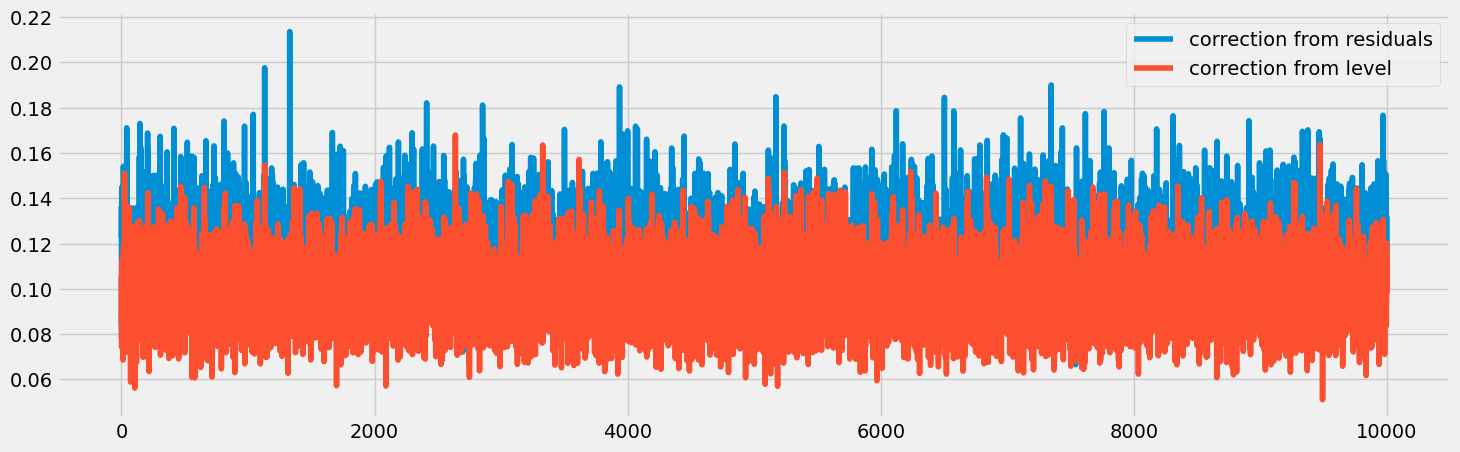

In [193]:
pd.DataFrame(corrections).plot(figsize=(16,5))